In [1]:
# import package
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Package untuk visualisasi
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

#Gunakan data scanner_data.csv untuk RFM Analysis!

In [2]:
import os
from google.colab import drive
drive.mount('/content/drive')
path_data = '/content/drive/My Drive/MSIB/Datasets/'

Mounted at /content/drive


In [3]:
os.listdir(path_data)

['retail_raw_test.csv',
 'release_dates.csv',
 'customer.csv',
 'reciepts.csv',
 'house_pricing.csv',
 'ab_data.csv',
 'data_sample_ab_testing.csv',
 'passenger.csv',
 'sales.csv',
 'titanic.csv',
 'Iris.csv',
 'free_advertising_data.csv',
 'TestMatches_Dataset.csv',
 'winequalityN.csv',
 'salesmonthly.csv',
 'airquality.csv',
 'spam.csv',
 'creditcard.csv',
 'house_prices.csv',
 'Data wine aroma.csv',
 'TelcoChurn.csv',
 'loan_prediction.csv',
 'HousingData.csv',
 'customer_segments.csv',
 'Clustering_product.csv',
 'scanner_data.csv',
 'data_RFM.csv']

In [4]:
df = pd.read_csv(path_data + "scanner_data.csv")
df.head()

,Unnamed: 0,Date,Customer_ID,Transaction_ID,SKU_Category,SKU,Quantity,Sales_Amount
0,1,02/01/2016,2547,1,X52,0EM7L,1.0,3.13
1,2,02/01/2016,822,2,2ML,68BRQ,1.0,5.46
2,3,02/01/2016,3686,3,0H2,CZUZX,1.0,6.35
3,4,02/01/2016,3719,4,0H2,549KK,1.0,5.59
4,5,02/01/2016,9200,5,0H2,K8EHH,1.0,6.88


#Apakah terdapat missing value dalam data?

In [5]:
df.isnull().sum()

Unnamed: 0        0
Date              0
Customer_ID       0
Transaction_ID    0
SKU_Category      0
SKU               0
Quantity          0
Sales_Amount      0
dtype: int64

tidak ada missing value

#Apakah ada data yang minus? Gunakan data yang bernilai positif untuk analysis ya!

In [6]:
df.describe()

,Unnamed: 0,Customer_ID,Transaction_ID,Quantity,Sales_Amount
count,131706.000000,131706.000000,131706.000000,131706.000000,131706.000000
mean,65853.500000,12386.450367,32389.604187,1.485311,11.981524
std,38020.391614,6086.447552,18709.901238,3.872667,19.359699
min,1.000000,1.000000,1.000000,0.010000,0.020000
25%,32927.250000,7349.000000,16134.000000,1.000000,4.230000
50%,65853.500000,13496.000000,32620.000000,1.000000,6.920000
75%,98779.750000,17306.000000,48548.000000,1.000000,12.330000
max,131706.000000,22625.000000,64682.000000,400.000000,707.730000


tidak ada data yang nilainya minus/negatif

#Hilangkan kolom No!

In [7]:
df = df.drop(columns=["Unnamed: 0"])

In [8]:
df.head()

,Date,Customer_ID,Transaction_ID,SKU_Category,SKU,Quantity,Sales_Amount
0,02/01/2016,2547,1,X52,0EM7L,1.0,3.13
1,02/01/2016,822,2,2ML,68BRQ,1.0,5.46
2,02/01/2016,3686,3,0H2,CZUZX,1.0,6.35
3,02/01/2016,3719,4,0H2,549KK,1.0,5.59
4,02/01/2016,9200,5,0H2,K8EHH,1.0,6.88


#Lakukan eksplor data experiment mengenai jumlah transaksi, banyaknya produk dan jumlah customer yang ada!

In [9]:
# Melihat jumlah produk, transaksi, dan pelanggan
cust_x_prod = pd.DataFrame({
    'quantity': [len(df['SKU'].value_counts()),
                 len(df['Transaction_ID'].value_counts()),
                 len(df['Customer_ID'].value_counts())]
}, index=['products', 'transactions', 'customers'])

print(cust_x_prod)


              quantity
products          5242
transactions     64682
customers        22625


Apakah kolom data sudah memiliki tipe data yang sesuai? Jika belum, ubahlah dulu tipe datanya agar sesuai.

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 131706 entries, 0 to 131705
Data columns (total 7 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   Date            131706 non-null  object 
 1   Customer_ID     131706 non-null  int64  
 2   Transaction_ID  131706 non-null  int64  
 3   SKU_Category    131706 non-null  object 
 4   SKU             131706 non-null  object 
 5   Quantity        131706 non-null  float64
 6   Sales_Amount    131706 non-null  float64
dtypes: float64(2), int64(2), object(3)
memory usage: 7.0+ MB


In [11]:
df.tail()

,Date,Customer_ID,Transaction_ID,SKU_Category,SKU,Quantity,Sales_Amount
131701,04/07/2016,20203,32900,IEV,FO112,3.0,6.46
131702,04/07/2016,20203,32900,N8U,I36F2,1.0,4.50
131703,04/07/2016,20203,32900,U5F,4X8P4,1.0,5.19
131704,04/07/2016,20203,32900,0H2,ZVTO4,1.0,4.57
131705,04/07/2016,20203,32900,Q4N,QM9BP,1.0,13.68


kolom date perlu dirubah agar formatnya sama

In [12]:
# ambil data paling terahir dari transaksi
import datetime as dt
now = dt.date(2016,12,31)

In [13]:
df['date'] = pd.DatetimeIndex(df.Date).date

In [14]:
df.head()

,Date,Customer_ID,Transaction_ID,SKU_Category,SKU,Quantity,Sales_Amount,date
0,02/01/2016,2547,1,X52,0EM7L,1.0,3.13,2016-02-01
1,02/01/2016,822,2,2ML,68BRQ,1.0,5.46,2016-02-01
2,02/01/2016,3686,3,0H2,CZUZX,1.0,6.35,2016-02-01
3,02/01/2016,3719,4,0H2,549KK,1.0,5.59,2016-02-01
4,02/01/2016,9200,5,0H2,K8EHH,1.0,6.88,2016-02-01


#Kapan terakhir ada transaksi?

In [15]:
df['Date'] = pd.to_datetime(df['Date'])
tanggal_terakhir_transaksi = df['Date'].max()
print("Tanggal terakhir kali terjadi transaksi:", tanggal_terakhir_transaksi)

Tanggal terakhir kali terjadi transaksi: 2016-12-31 00:00:00


#Lakukan RFM Analysis!
##Bagaimana recency pelanggan?

In [16]:
# Group by berdasarkan customer terahir membeli
recency_df = df.groupby(['Customer_ID'], as_index = False)['date'].max()
recency_df.columns = ['Customer_ID','Date']
recency_df.head()

,Customer_ID,Date
0,1,2016-01-22
1,2,2016-06-19
2,3,2016-02-01
3,4,2016-11-07
4,5,2016-09-02


In [17]:
# Hitung seberapa sering dia membeli dengan mengacu pada tanggal terbaru dalam beberapa hari
recency_df['Recency'] = recency_df.Date.apply(lambda x : (now - x).days)
recency_df.head()

,Customer_ID,Date,Recency
0,1,2016-01-22,344
1,2,2016-06-19,195
2,3,2016-02-01,334
3,4,2016-11-07,54
4,5,2016-09-02,120


In [18]:
recency_df.tail()

,Customer_ID,Date,Recency
22620,22621,2016-10-12,80
22621,22622,2016-12-16,15
22622,22623,2016-12-21,10
22623,22624,2016-02-12,323
22624,22625,2016-12-31,0


Bagaimana frequency pelanggan?

In [19]:
# Periksa frekuensi pelanggan (sudah berapa kali transaksi)
frequency_df = df.copy()
frequency_df.drop_duplicates(subset = ['Customer_ID','Transaction_ID'], keep = "first", inplace = True)
frequency_df = frequency_df.groupby('Customer_ID', as_index = False)['Transaction_ID'].count()
frequency_df.columns = ['Customer_ID','Frequency']
frequency_df.head()

,Customer_ID,Frequency
0,1,1
1,2,2
2,3,1
3,4,2
4,5,5


Bagaimana monetary pelanggan?

In [20]:
monetary_df = df.groupby('Customer_ID', as_index = False)['Sales_Amount'].sum()
monetary_df.columns = ['Customer_ID','Monetary']
monetary_df.head()

,Customer_ID,Monetary
0,1,16.29
1,2,22.77
2,3,10.92
3,4,33.29
4,5,78.82


Gabungkan recency, frequency dan monetary pelanggan dalam satu tabel!

In [22]:
# Mengkombinasikan fires Recency dan Frequency
rf = recency_df.merge(frequency_df, left_on = "Customer_ID", right_on="Customer_ID")

In [24]:
# combine RF frame dengan monetary Values
rfm = rf.merge(monetary_df, left_on = 'Customer_ID', right_on = 'Customer_ID')
rfm.set_index("Customer_ID", inplace = True)
rfm.head()

,Date,Recency,Frequency,Monetary
Customer_ID,,,,
1,2016-01-22,344,1,16.29
2,2016-06-19,195,2,22.77
3,2016-02-01,334,1,10.92
4,2016-11-07,54,2,33.29
5,2016-09-02,120,5,78.82


In [26]:
rfm.drop(columns = ['Date'], inplace = True )
rfm.head()

,Recency,Frequency,Monetary
Customer_ID,,,
1,344,1,16.29
2,195,2,22.77
3,334,1,10.92
4,54,2,33.29
5,120,5,78.82


Buatlah pengunaan klasifikasi quartile untuk menentukan limit dari setiap klasifikasinya!

In [25]:
quantiles = rfm.quantile(q = [0.25, 0.5, 0.75])
quantiles

,Recency,Frequency,Monetary
0.25,44.0,1.0,10.17
0.50,120.0,1.0,23.85
0.75,242.0,3.0,63.07


In [27]:
RFMScores = rfm.copy()

#Recency scoring
def Rscoring (x,p,d):
  if x <= d[p][0.25]:
    return 1
  elif x <= d[p][0.50]:
    return 2
  elif x <= d[p][0.75]:
    return 3
  else:
    return 4

# Frequency and Monetary Scoring
def FMscoring (x,p,d):
  if x <= d[p][0.25]:
    return 4
  elif x <= d[p][0.50]:
    return 3
  elif x <= d[p][0.75]:
    return 2
  else:
    return 1

In [28]:
RFMScores['R'] = RFMScores['Recency'].apply(Rscoring, args = ('Recency', quantiles))
RFMScores['F'] = RFMScores['Frequency'].apply(FMscoring, args = ('Frequency', quantiles))
RFMScores['M'] = RFMScores['Monetary'].apply(FMscoring, args = ('Monetary', quantiles))

RFMScores['RFMgroup'] = RFMScores.R.map(str) + RFMScores.F.map(str) + RFMScores.M.map(str)
RFMScores['Score'] = RFMScores[['R','F','M']].sum(axis = 1)
print(RFMScores.head())

             Recency  Frequency  Monetary  R  F  M RFMgroup  Score
Customer_ID                                                       
1                344          1     16.29  4  4  3      443     11
2                195          2     22.77  3  2  3      323      8
3                334          1     10.92  4  4  3      443     11
4                 54          2     33.29  2  2  2      222      6
5                120          5     78.82  2  1  1      211      4


Lakukan Clustering K-means!

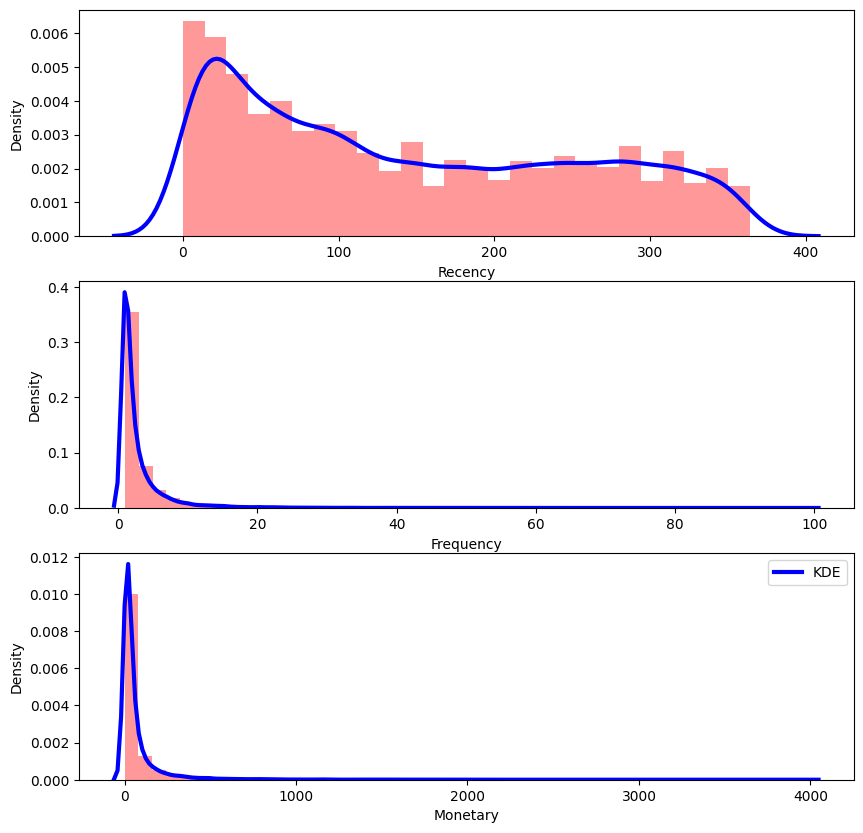

In [29]:
# melihat distribusi data hasil RFM SCORE

plt.figure(figsize=(10, 10))

plt.subplot(3, 1, 1)
sns.distplot(rfm['Recency'], kde_kws={'color': 'b', 'lw': 3, 'label': 'KDE'}, hist_kws={'color': 'r'})
plt.subplot(3, 1, 2)
sns.distplot(rfm['Frequency'], kde_kws={'color': 'b', 'lw': 3, 'label': 'KDE'}, hist_kws={'color': 'r'})
plt.subplot(3, 1, 3)
sns.distplot(rfm['Monetary'], kde_kws={'color': 'b', 'lw': 3, 'label': 'KDE'}, hist_kws={'color': 'r'})

plt.legend()
plt.show()



In [30]:
clustering_RFM = rfm[['Recency','Frequency','Monetary']].copy()
clustering_RFM.head()

,Recency,Frequency,Monetary
Customer_ID,,,
1,344,1,16.29
2,195,2,22.77
3,334,1,10.92
4,54,2,33.29
5,120,5,78.82


In [31]:
min_max_scaler = MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(clustering_RFM)
data_scaled = pd.DataFrame(x_scaled, columns = ['Recency','Frequency','Monetary'])
data_scaled

,Recency,Frequency,Monetary
0,0.945055,0.000000,0.004052
1,0.535714,0.010204,0.005678
2,0.917582,0.000000,0.002705
3,0.148352,0.010204,0.008317
4,0.329670,0.040816,0.019740
...,...,...,...
22620,0.219780,0.000000,0.002396
22621,0.041209,0.000000,0.001488
22622,0.027473,0.000000,0.032081
22623,0.887363,0.000000,0.004882


###***nentuin nilai K dulu pakai ELBOW METHOD***
Gunakan ELbow methode untuk menentukan jumlah cluster.

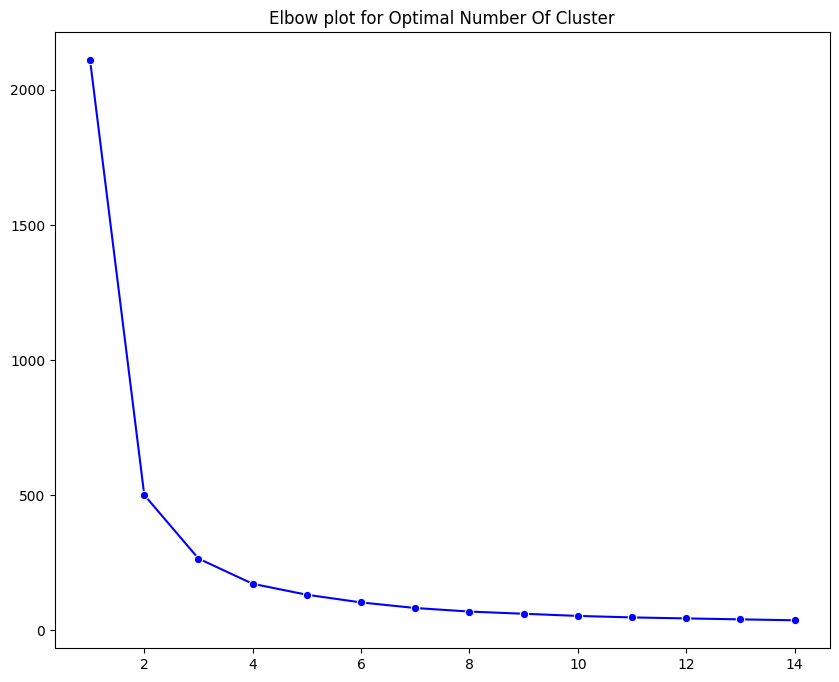

In [32]:
wscc = []
for i in range(1, 15):
    kmeans = KMeans(n_clusters=i, init="k-means++", random_state=0)  # Perbaikan pada parameter init
    kmeans.fit(data_scaled)
    wscc.append(kmeans.inertia_)

plt.figure(figsize=(10, 8))
sns.lineplot(x=range(1, 15), y=wscc, marker="o", color='blue')  # Perbaikan pada parameter c
plt.title("Elbow plot for Optimal Number Of Cluster")
plt.show()


In [33]:
range_n_clusters = range(2, 10)
best_score = -1
best_k = -1

for n_clusters in range_n_clusters:
    clusterer = KMeans(n_clusters)
    preds = clusterer.fit_predict(data_scaled)
    score = silhouette_score(data_scaled, preds)

    print("For n_clusters = {}, silhouette score is {}".format(n_clusters, score))

    if score > best_score:
        best_score = score
        best_k = n_clusters

print("Best silhouette score is {} for n_clusters = {}".format(best_score, best_k))

For n_clusters = 2, silhouette score is 0.6482597094915471
For n_clusters = 3, silhouette score is 0.5688621757077823
For n_clusters = 4, silhouette score is 0.5283462758569374
For n_clusters = 5, silhouette score is 0.4963172614198482
For n_clusters = 6, silhouette score is 0.510121028479646
For n_clusters = 7, silhouette score is 0.49043689470505164
For n_clusters = 8, silhouette score is 0.4706874447267856
For n_clusters = 9, silhouette score is 0.4544994305072613
Best silhouette score is 0.6482597094915471 for n_clusters = 2


Terlihat sudut perubhan terbesar ada pada cluster 2

###Berapa cluster yang akan dibentuk dari Elbow methode? buatlah clusternya!

In [35]:
kmeans = KMeans(n_clusters = 2, random_state = 0, init = 'k-means++',
                n_init = 10, max_iter = 300).fit(data_scaled)


In [36]:
pred = kmeans.predict(data_scaled)
RFMScores['Clusters'] = kmeans.labels_
RFMScores.head(10)

,Recency,Frequency,Monetary,R,F,M,RFMgroup,Score,Clusters
Customer_ID,,,,,,,,,
1,344,1,16.29,4,4,3,443,11,1
2,195,2,22.77,3,2,3,323,8,1
3,334,1,10.92,4,4,3,443,11,1
4,54,2,33.29,2,2,2,222,6,0
5,120,5,78.82,2,1,1,211,4,0
6,275,1,25.55,4,4,2,442,10,1
7,235,1,17.84,3,4,3,343,10,1
8,193,1,9.78,3,4,4,344,11,1
9,286,1,15.75,4,4,3,443,11,1


Bagaimana hasil pengelompokan pelanggan dari analisis yang telah dilakukan?

In [37]:
RFMScores.groupby('Clusters').mean().sort_values('Score', ascending = False)

,Recency,Frequency,Monetary,R,F,M,Score
Clusters,,,,,,,
1,260.522497,1.503337,32.883394,3.601184,3.365985,2.880732,9.847901
0,63.516685,3.803225,95.429463,1.719535,2.418298,2.234871,6.372703


Dapat dilihat bahwa:

- Cluster 0 memiliki nilai recency yang signifikan lebih besar dibandingkan dengan Cluster 1. Hal ini menunjukkan bahwa banyaknya transaksi pembelian terjadi dalam rentang waktu terkini. Namun, individu yang melakukan pembelian cenderung tidak sering bertransaksi, dan tingkat pendapatan mereka cenderung kecil.
- Cluster 1 memiliki nilai Monetary yang jauh lebih besar dibandingkan dengan Cluster 0. Ini menunjukkan bahwa meskipun pelanggan dalam cluster ini jarang berbelanja, mereka cenderung memiliki tingkat kesetiaan yang tinggi dan sering kembali untuk bertransaksi. Selain itu, tingkat pendapatan mereka jauh lebih besar dibandingkan dengan pelanggan dalam Cluster 0.

Dengan demikian, terlihat adanya perbedaan perilaku pembelian dan karakteristik pendapatan antara dua kelompok pelanggan ini. Analisis ini dapat memberikan wawasan yang berharga untuk mengarahkan strategi pemasaran yang sesuai dengan setiap kelompok pelanggan.

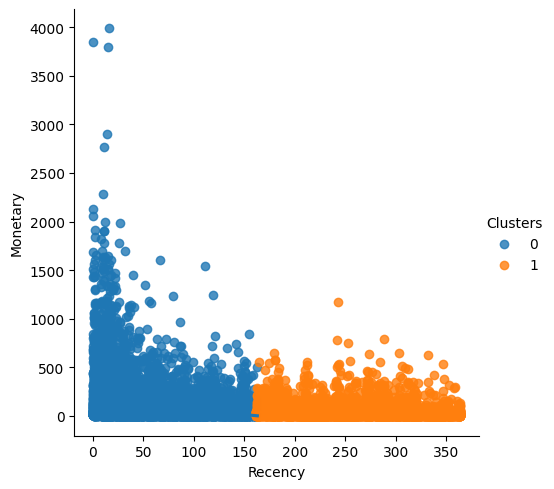

In [38]:
sns.lmplot(x = 'Recency', y='Monetary', data = RFMScores, hue = 'Clusters', fit_reg =True)


Dari hasil analisis di atas, dapat terlihat bahwa:

- Cluster 0 menunjukkan rentang recency yang umumnya berkisar antara 0 hingga 160.
- Cluster 1 memiliki rentang recency yang cenderung lebih tinggi, berkisar antara 160 hingga 375.

Hal ini mengindikasikan bahwa ada pola yang berbeda dalam frekuensi atau kedekatan interaksi dengan entitas yang diamati di antara dua kelompok tersebut. Analisis lebih lanjut mungkin diperlukan untuk memahami faktor-faktor apa yang menyebabkan perbedaan ini, serta implikasinya terhadap perilaku atau karakteristik yang diamati dari setiap kelompok.

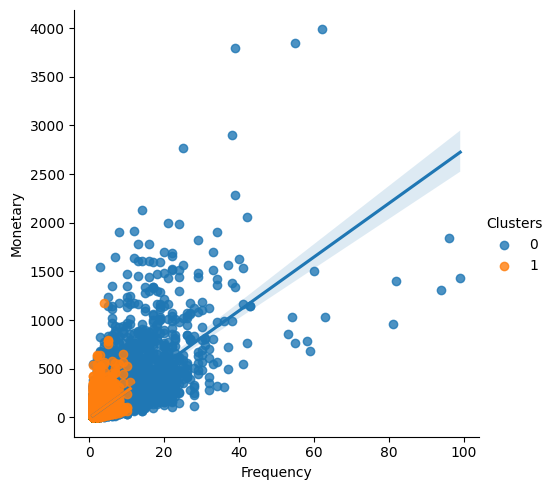

In [39]:
sns.lmplot(x = 'Frequency', y='Monetary', data = RFMScores, hue = 'Clusters')

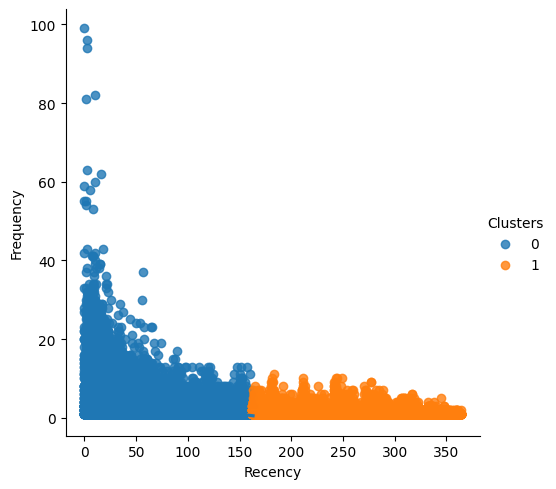

In [40]:
sns.lmplot(x = 'Recency', y='Frequency', data = RFMScores, hue = 'Clusters', fit_reg =True)